Idealised 2-D mantle convection with a free surface
=======================================================

In this tutorial we show how to include a free surface boundary condition
by modifying the 2-D case presented in our first tutorial.

Free Surface
------------
In the base case and other tutorials so far we have assumed that the top surface of the model is free-slip, i.e. the flow is free to move tangentially, but there is no normal flow across the top surface of the model. For a free surface we relax that condition so that the surface is able to deform.

Mathematically, the boundary conditions for a free surface can be written as
\begin{equation}
    \textbf{u} \cdot \textbf{n}  = \dfrac{\partial \eta}{\partial t}  \textbf{n}  \cdot \boldsymbol{\hat{r}},
\end{equation}
\begin{equation}
      \textbf{n} \cdot \boldsymbol{\sigma}  = \textbf{0},
\end{equation}
where $\textbf{u}$ is the velocity vector, $\textbf{n}$ is the unit normal, $\eta$ is the free surface height, $\boldsymbol{\hat{r}}$ is the radial unit vector and $\boldsymbol{\sigma}$ is the full stress tensor. The first equation states that the velocity of the free surface is just the normal velocity at the surface and the second equation states there is no stress acting at the free surface.

One way to implement the zero stress condition at the free surface is just to move the mesh based on the velocity calculated in the domain. This is a Lagrangian formulation.  There are a few downsides to this. Firstly, it can be expensive to continually update the mesh geometry at each timestep. We also have to reformulate our equations in terms of a moving reference frame accounting for the mesh velocity.

If we subtract off the hydrostatic pressure from the full stress tensor and define this as $\boldsymbol{\sigma }'$, then the new stress boundary condition becomes
\begin{equation}
      \textbf{n} \cdot \boldsymbol{\sigma }' \cdot \textbf{n}  = - \Delta\rho_{fs} g \eta,
\end{equation}
where $\Delta \rho_{fs}$ is the density contrast across the free surface and $g$ is gravity. Provided that deviations in the free surface are small, we can linearise the effect of the free surface by just applying the additional stress at the reference level $z = z_0$, instead of at the top of the free surface $z = \eta$. This means we can keep the mesh fixed in time and we do not have to change to a Lagrangian formulation.

A possibly more important consideration though, is that if we couple the free surface to the Stokes equations explicitly in time, there will always be a lag between the interior dynamics pushing the free surface up and the stabilising feedback due to deviations of the free surface from the reference level. If we take timesteps that are too long then the simulation becomes unstable. This timestep limitation is based on a characteristic relaxation time scale
\begin{equation}
\tau = \dfrac{2 k \mu}{\Delta \rho_{fs} g},
\end{equation}
where $k$ is a wavenumber, $\mu$ is the viscosity, $\Delta \rho_{fs}$ is the density contrast across the free surface and $g$ is gravity.

Note that long wavelengths decay fastest, so it is the longest waves that dictate the maximum stable timestep for an explicit free surface implementation. Usually, the timestep is controlled by an advection CFL condition calculated from the energy equation, however, a stable free surface timestep might be much lower than this estimate. This means that a free surface simulation with explicit timestepping may be an order of magnitude slower than an equivalent free-slip simulation.

A way around this problem is to solve for the free surface height implicitly, i.e. at the same time as the velocity and pressure during the Stokes solve. By coupling the solution of velocity, pressure and the free surface together, there is no longer a timestep constraint. The decay of the (long) wavelengths with decay times shorter than the timestep are effectively damped by numerical diffusion. The upshot is we can take longer timesteps, so the simulation time is similar to a free-slip simulation, whilst being able to investigate time dependent short wavelength changes of the free surface. We have implemented the second order $\theta$ timestepping method from Kramer et al. (2012) and we point the reader to this paper for a longer discussion of the different approaches and their implementation.

### References
*Kramer, S. C., Wilson, C. R., & Davies, D. R. (2012).* ***An implicit free surface algorithm for geodynamical simulations.*** *Physics of the Earth and Planetary Interiors, 194, 25-37.*


This example
------------

We are going to extend the basic mantle dynamics problem from Blankenbach et al.
(1989) to include a free surface on the top.

As with all examples, the first step is to import the gadopt module, which
provides access to Firedrake and associated functionality.

In [1]:
from gadopt import *

In [2]:
# Next we define a mesh using the same geometry and grid resolution as the
# first tutorial.

nx, ny = 40, 40  # Number of cells in x and y directions.
mesh = UnitSquareMesh(nx, ny, quadrilateral=True)  # Square mesh generated via firedrake
mesh.cartesian = True
boundary = get_boundary_ids(mesh)  # Boundary IDs

Now we set up the function spaces. As before we use Q2 and Q1 for the velocity
and pressure fields, along with Q2 for the temperature field. The key difference
is that we now have an additional variable to solve for: the free surface height, $\eta$!

Since we are solving for $\eta$ at the new timestep implicitly, i.e. at the same time as
solving for velocity and pressure, we need to expand the mixed function space to include
the free surface function space. Since the free surface height acts as a
boundary condition on the pressure we will use Q1 to discretise the free surface.

In [3]:
V = VectorFunctionSpace(mesh, "CG", 2)  # Velocity function space (vector)
W = FunctionSpace(mesh, "CG", 1)  # Pressure and free surface function space (scalar)
Q = FunctionSpace(mesh, "CG", 2)  # Temperature function space (scalar)
Z = MixedFunctionSpace([V, W, W])  # Mixed function space for velocity, pressure and eta.

In [4]:
z = Function(Z)  # A field over the mixed function space Z.
u, p, eta = split(z)  # Returns symbolic UFL expression for u, p and eta
z.subfunctions[0].rename("Velocity")
z.subfunctions[1].rename("Pressure")
z.subfunctions[2].rename("eta")

As with the base case we specify the Boussinesq approximation and the Rayleigh
number for the simulation.

In [5]:
Ra = Constant(1e4)  # Rayleigh number
approximation = BoussinesqApproximation(Ra)

We also specify a timestep adaptor as before.

In [6]:
time = 0.0  # Initial time
delta_t = Constant(1e-6)  # Initial time-step
timesteps = 20000  # Maximum number of timesteps
t_adapt = TimestepAdaptor(delta_t, u, V, maximum_timestep=0.1, increase_tolerance=1.5)
steady_state_tolerance = 1e-9

We set up the initial conditions for the temperature field.

In [7]:
X = SpatialCoordinate(mesh)
T = Function(Q, name="Temperature")
T.interpolate((1.0 - X[1]) + (0.05 * cos(pi * X[0]) * sin(pi * X[1])))

Coefficient(WithGeometry(FunctionSpace(<firedrake.mesh.MeshTopology object at 0x752d790be930>, FiniteElement('Q', quadrilateral, 2), name=None), Mesh(VectorElement(FiniteElement('Q', quadrilateral, 1), dim=2), 0)), 15)

As we are applying a free surface boundary condition on the top surface
there is now a constraint on pressure. This means the solution for pressure
does not contain a nullspace, so we can skip the step of creating a nullspace object.

Next we define the boundary conditions. As before we set no normal flow
on the bottom and sides of the box using strong Dirichlet boundary conditions.

However, on the top of the box we specify a free surface using a keyword argument.
Since this is a nondimensional simulation we specify a free surface Rayleigh number,
$$Ra_{FS} = Ra B_{fs}, $$
where the Rayleigh number is given by
$$Ra = \frac{\rho_0 \alpha \Delta T gd^3}{\mu \kappa} $$
where $\rho_0$ is the reference density, $\alpha$ is the thermal expansion coefficient, $\Delta T$ is a characteristic change in temperature across the mantle, $g$ is gravitational acceleration, $d$ is the characteristic length scale used during non dimensionalisation, $\mu$ is the Dynamic viscosity and $\kappa$ is the thermal diffusivity.

The free surface buoyancy number is given by
$$B_{fs} = \frac{\Delta \rho_{0FS}}{\rho_0 \alpha \Delta T} ,$$
where $\Delta \rho_{0FS} = \rho_0 - \rho_{ext}$, i.e. the density difference between the reference density and the exterior density.

Simplifying,
$$Ra_{FS} = \frac{\Delta \rho_{0FS}gd^3}{\mu \kappa},$$

Typically, when the exterior density is negligbile compared with the interior density (i.e. air vs rock!) and with $\alpha$ = 3x10$^{-5}$ K$^{-1}$ and $\Delta T$ = 3000 K, $B_{fs}$ is about 10. For dimensional simulations you can specify the density contrast across the free surface with *delta_rho_fs* through the free surface dictionary, as well as providing $\rho_0$ and $g$ through the approximation object in the usual way.

In [8]:
Bfs = 10.  # Free surface buoyancy number

stokes_bcs = {
    boundary.bottom: {"uy": 0},
    boundary.top: {"free_surface": {"RaFS": Ra*Bfs}},
    boundary.left: {"ux": 0},
    boundary.right: {"ux": 0},
}

temp_bcs = {
    boundary.bottom: {"T": 1.0},
    boundary.top: {"T": 0.0},
}

Let's setup some output files.

In [9]:
output_file = VTKFile("output.pvd")
output_frequency = 10

plog = ParameterLog("params.log", mesh)
plog.log_str(
    "timestep time dt maxchange u_rms u_rms_surf ux_max nu_top nu_base energy avg_t eta_min eta_max"
)

gd = GeodynamicalDiagnostics(z, T, boundary.bottom, boundary.top)

Now let's setup the solver objects.

First of all, as the Stokes equation now includes a time dependent
boundary condition we need to pass the timestep to the Stokes solver.

Also it is important to make sure that the *constant_jacobian* option is switched to *False* if the
free surface is used in combination with adaptive timestepping! For the base case we
can make the simulation a bit faster by only building the Stokes block matrix associated
with the LHS of the Stokes equations at the first timestep, because none of the prefactors
change in time. However, the timestep appears on the LHS of the equations when the free
surface is activated, so we need to reassamble this block matrix at each timestep if we use an adapative timestepping method.

In [10]:
energy_solver = EnergySolver(
    T, u, approximation, delta_t, ImplicitMidpoint, bcs=temp_bcs
)

stokes_solver = StokesSolver(
    z, T, approximation, bcs=stokes_bcs, constant_jacobian=False, free_surface_dt=delta_t
)


Now let's run the simulation!

In [11]:
for timestep in range(0, timesteps):
    # Write output:
    if timestep % output_frequency == 0:
        output_file.write(*z.subfunctions, T)

    dt = t_adapt.update_timestep()
    time += dt

    # Solve Stokes sytem:
    stokes_solver.solve()

    # Temperature system:
    energy_solver.solve()

    # Compute diagnostics:
    energy_conservation = abs(abs(gd.Nu_top()) - abs(gd.Nu_bottom()))

    # Calculate L2-norm of change in temperature:
    maxchange = sqrt(assemble((T - energy_solver.T_old) ** 2 * dx))

    # Log diagnostics:
    plog.log_str(
        f"{timestep} {time} {float(delta_t)} {maxchange} "
        f"{gd.u_rms()} {gd.u_rms_top()} {gd.ux_max(boundary.top)} {gd.Nu_top()} "
        f"{gd.Nu_bottom()} {energy_conservation} {gd.T_avg()} "
        f"{z.subfunctions[2].dat.data.min()} {z.subfunctions[2].dat.data.max()}"
    )

    # Leave if steady-state has been achieved:
    if maxchange < steady_state_tolerance:
        log("Steady-state achieved -- exiting time-step loop")
        break

Steady-state achieved -- exiting time-step loop


At the end of the simulation, once a steady-state has been achieved, we close our logging file
and checkpoint steady state temperature and Stokes solution fields to disk. These can later be
used to restart a simulation, if required.

In [12]:
plog.close()

with CheckpointFile("Final_State.h5", "w") as final_checkpoint:
    final_checkpoint.save_mesh(mesh)
    final_checkpoint.save_function(T, name="Temperature")
    final_checkpoint.save_function(z, name="Stokes")

Let's use the python package **PyVista** to plot the temperature field through time. We will use the calculated free surface height to artifically scale the mesh in the vertical direction. We have exaggerated the vertical stretching by a factor of 1.5, **BUT...** it is important to remember this is just for ease of visualisation - the mesh is not moving in reality!

In [13]:
import matplotlib.pyplot as plt
import pyvista as pv

# Read the PVD file
reader = pv.get_reader("output.pvd")
data = reader.read()[0]  # MultiBlock mesh with only 1 block

# Create a plotter object
plotter = pv.Plotter(shape=(1, 1), border=False, notebook=True, off_screen=False)

# Open a gif
plotter.open_gif("temperature_warp.gif")

# Make a colour map
boring_cmap = plt.get_cmap("coolwarm", 25)

for i in range(len(reader.time_values)):
    reader.set_active_time_point(i)
    data = reader.read()[0]

    # Artificially warp the output data in the vertical direction by the free surface height
    warped = data.warp_by_scalar(scalars="eta", normal=(0, 1, 0), factor=1.5)

    # Add the warped temperature field to the frame
    plotter.add_mesh(
        warped,
        scalars="Temperature",
        lighting=False,
        show_edges=False,
        clim=[0, 1],
        cmap=boring_cmap,
        scalar_bar_args={"position_x": 0.2, "position_y": 0.05}
    )
    arrows = data.glyph(orient="Velocity", scale="Velocity", factor=0.001, tolerance=0.05)
    plotter.add_mesh(arrows, color="black")
    # Centre camera on xy plane and write frame
    plotter.camera_position = "xy"
    plotter.write_frame()
    plotter.clear()

# Closes and finalizes movie
plotter.close()

![SegmentLocal](temperature_warp.gif "segment")

As before with the base case, the buoyancy differences due to the starting temperature configuration drives an overturning flow. You should see that the temperature field at the final time is very similar to the base case result - in fact they are the same!

Given this problem reaches a steady state adding a free surface should not change that behaviour, it will just change how the simulation reaches that steady state. We can see that the free surface has been pushed up above regions of hotter mantle, where thermal convection is driving positive vertical flow and is sinking where there is colder mantle below, which all makes intuitive sense.



We can even verify that the stress exerted by the deviation of the free surface from the reference state is the same as the when calculating dynamic topography from a free-slip simulation. As a recap the free surface normal boundary condition is

\begin{equation}
      \textbf{n} \cdot \boldsymbol{\sigma }' \cdot \textbf{n}  = - \Delta\rho_{FS} g \eta.
\end{equation}

In 2D, on the top surface, this simplifies to
\begin{equation}
     -p'  + 2\mu \frac{\partial v}{\partial y }  = - \Delta\rho_{FS} g \eta.
\end{equation}

For a nondimensional simulation this simplifies to
\begin{equation}
     -p_{\star}'  + 2 \frac{\partial v_{\star}}{\partial y_{\star} }  = - Ra_{FS} \eta_{\star}+ Ra T_{\star}   \eta_{\star},
\end{equation}
where $\star$ indicates a nondimensional variable. Rearranging, our expected dynamic topography at steady state would be
\begin{equation}
     \eta_{\star} = \dfrac{-p_{\star}'  + 2 \frac{\partial v_{\star}}{\partial y_{\star} }}{ Ra T_{\star}- Ra_{FS} }.
\end{equation}

First let's load the final state from the base case and calculate the expected dynamic topography with the code below.

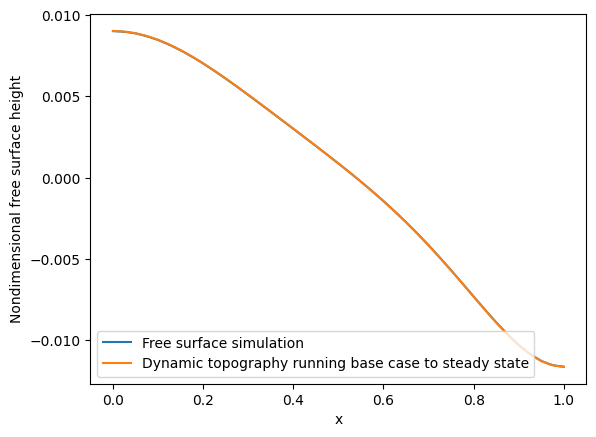

In [14]:
# load velocity and pressure from final state of the base case run (from a simulation we saved earlier!).
with CheckpointFile("../base_case/Final_State.h5", "r") as f:
    mesh_base = f.load_mesh()
    z_base = f.load_function(mesh_base, "Stokes")
    T_base = f.load_function(mesh_base, "Temperature")

# Create a P1 functionspace on the mesh used for the base case simulation
W_base = FunctionSpace(mesh_base, "CG", 1)

# Store the dynamic topography calculated from the stress on the top
# surface after running the base case to steady state
eta_base_steady = Function(W_base, name="final_eta_base")
eta_base_steady.interpolate((-z_base.subfunctions[1] + 2 * Dx(z_base.subfunctions[0][1], 1))/(Ra*T_base-Ra*10))

# project out the constant associated with the pressure nullspace for the base case as all boundaries are closed
coef = assemble(eta_base_steady * ds(boundary.top))/assemble(Constant(1.0)*ds(boundary.top, domain=mesh_base))
eta_base_steady.project(eta_base_steady - coef)

# Interpolate the base case dynamic topography field onto the original mesh for plotting
eta_steady_original = assemble(interpolate(eta_base_steady, W))
eta_steady_original.rename("final_eta_base")

# Write out combined eta and base case dynamic topography file
combined_eta_file = VTKFile("combined_eta.pvd")
combined_eta_file.write(z.subfunctions[2], eta_steady_original)

# Read combined eta file
eta_reader = pv.get_reader("combined_eta.pvd")
data_eta = eta_reader.read()[0]

# Sample the combined eta file along the top surface of the mesh
a = [0, 1, 0]  # Top left corner of domain
b = [1, 1, 0]  # Top right corner of domain
data_eta_array = data_eta.sample_over_line(
    a,
    b,
    resolution=100)

# Plot the final free surface height with the dynamic topo calculated from running base case to steady state
plt.figure()
x = np.linspace(0,1,num=101)
plt.plot(x, data_eta_array["eta"], label="Free surface simulation")
plt.plot(x, data_eta_array["final_eta_base"], label="Dynamic topography running base case to steady state")
plt.xlabel("x")
plt.ylabel("Nondimensional free surface height")
plt.legend()
plt.show()

As you can see this matches the final free surface height that our example converges towards.

A final point for this tutorial is that more rigorous tests check the order of convergence to an analytical solution as the timestep or gridsize are refined. The interested reader can take a look at the free surface test directory where we have confirmed this behaviour for a number of test cases (including top and bottom free surfaces) from Kramer et al. (2012).